<a href="https://colab.research.google.com/github/chaesang/Coursera_Capstone/blob/master/Busan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries.


In [1]:
import folium # map rendering library

import requests
import pandas as pd
import numpy as np

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


Preparation for Foursquare API

In [2]:
CLIENT_ID = '5POTHYS1G4EPGFBD1B1JMRWZOEUYJTU4DVLVZEWBSDTVADXH' # your Foursquare ID
CLIENT_SECRET = 'HNMG10BGT1AZDEWDD0KODU4U4T4DOV03RFXRA0XFYSRXC4M2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5POTHYS1G4EPGFBD1B1JMRWZOEUYJTU4DVLVZEWBSDTVADXH
CLIENT_SECRET:HNMG10BGT1AZDEWDD0KODU4U4T4DOV03RFXRA0XFYSRXC4M2


Lat / Long of Busan ( https://www.latlong.net/place/busan-south-korea-27604.html )

In [3]:
busan_lat = 35.166668
busan_long = 129.066666

Base map for Busan

In [4]:
map_busan = folium.Map(width=800,height=500, location=[busan_lat, busan_long], zoom_start=11)
map_busan


Get stations: Metro station + Light rail station.

In [5]:
# Common function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [6]:
LIMIT = 300
radius = 30000
category_id = '4bf58dd8d48988d1fd931735' # Metro Stations

url = 'https://api.foursquare.com/v2/venues/explore?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    category_id,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    busan_lat,
    busan_long, 
    radius,
    LIMIT
)
url

'https://api.foursquare.com/v2/venues/explore?categoryId=4bf58dd8d48988d1fd931735&client_id=5POTHYS1G4EPGFBD1B1JMRWZOEUYJTU4DVLVZEWBSDTVADXH&client_secret=HNMG10BGT1AZDEWDD0KODU4U4T4DOV03RFXRA0XFYSRXC4M2&v=20180605&ll=35.166668,129.066666&radius=30000&limit=300'

In [7]:
requests.get(url).json()

{'meta': {'code': 200, 'requestId': '5f1a91995dc8d450a1e7aa35'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4bf3d378354e9c74c3a62602-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/subway_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d1fd931735',
         'name': 'Metro Station',
         'pluralName': 'Metro Stations',
         'primary': True,
         'shortName': 'Metro'}],
       'id': '4bf3d378354e9c74c3a62602',
       'location': {'address': '중앙대로 지하 786',
        'cc': 'KR',
        'country': '대한민국',
        'crossStreet': '부산1호선',
        'distance': 567,
        'formattedAddress': ['중앙대로 지하 786 (부산1호선)',
         'Busanjin - gu',
         '부산광역시',
         '614-848',
         '대한민국'],
        'labeledLatLngs': [{'label': 'display',

In [8]:

metro_stations = requests.get(url).json()['response']['groups'][0]['items']
metro_stations = pd.json_normalize(metro_stations) # flatten JSON

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
metro_stations = metro_stations.loc[:, filtered_columns]

metro_stations['venue.categories'] = metro_stations.apply(get_category_type, axis=1)
metro_stations.columns = [col.split(".")[-1] for col in metro_stations.columns]

metro_stations.shape

(100, 4)

Light rail station


In [9]:
LIMIT = 300
radius = 30000
category_id = '4bf58dd8d48988d1fc931735' # Light Rail Station

url = 'https://api.foursquare.com/v2/venues/explore?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    category_id,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    busan_lat,
    busan_long, 
    radius,
    LIMIT
)
url

'https://api.foursquare.com/v2/venues/explore?categoryId=4bf58dd8d48988d1fc931735&client_id=5POTHYS1G4EPGFBD1B1JMRWZOEUYJTU4DVLVZEWBSDTVADXH&client_secret=HNMG10BGT1AZDEWDD0KODU4U4T4DOV03RFXRA0XFYSRXC4M2&v=20180605&ll=35.166668,129.066666&radius=30000&limit=300'

In [10]:

lrail_stations = requests.get(url).json()['response']['groups'][0]['items']
lrail_stations = pd.json_normalize(lrail_stations) # flatten JSON

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
lrail_stations = lrail_stations.loc[:, filtered_columns]

lrail_stations['venue.categories'] = lrail_stations.apply(get_category_type, axis=1)
lrail_stations.columns = [col.split(".")[-1] for col in lrail_stations.columns]

lrail_stations.shape

(33, 4)

Merge metro station and light rail station.

In [11]:
stations = pd.concat([metro_stations,lrail_stations], ignore_index=True)
stations.shape

(133, 4)

In [12]:
stations


,name,categories,lat,lng
0,Bujeon Stn. (부전역),Metro Station,35.162565,129.062973
1,Seomyeon Stn. (서면역),Metro Station,35.157718,129.059181
2,Yeonsan Stn. (연산역),Metro Station,35.186107,129.081523
3,Yangjeong Stn. (양정역),Metro Station,35.173009,129.071133
4,Sajik Stn. (사직역),Metro Station,35.199044,129.065065
...,...,...,...,...
128,Royal Tomb of King Suro Stn. (수로왕릉역),Light Rail Station,35.232799,128.872129
129,Gimhae Nat'l Museum Stn. (박물관역),Light Rail Station,35.240002,128.871828
130,Yeonji Park Stn. (연지공원역),Light Rail Station,35.249597,128.869291
131,Presbyterian Univ. Stn. (장신대역),Light Rail Station,35.259436,128.867172


Create map for Busan with stations.


In [13]:
for lat, lng, station in zip(stations['lat'],
                          stations['lng'],
                          stations['name']):
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(map_busan)
    
map_busan


####Defining a function to fetch top  venues around a given neighborhood


In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['_Station', 
                  'Station Latitude', 
                  'Station Longitude', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)

#### Generating Venues

In [15]:
busan_venues = getNearbyVenues(names=stations['name'],
                               latitudes=stations['lat'],
                               longitudes=stations['lng']
                              )

Bujeon Stn. (부전역)
Seomyeon Stn. (서면역)
Yeonsan Stn. (연산역)
Yangjeong Stn. (양정역)
Sajik Stn. (사직역)
Jeonpo Stn. (전포역)
Geojehaemaji Stn. (거제해맞이역)
Bujeon Stn. - Korail (부전역)
City Hall Stn. (시청역)
Buam Stn. (부암역)
Mulmangol Stn. (물만골역)
Beomnaegol Stn. (범내골역)
Busan Int'l Finance Center·Busan Bank Stn. (국제금융센터·부산은행역)
Gaya Stn. (가야역)
Geoje Stn. (거제역)
Sports Complex Stn. (종합운동장역)
Baesan Stn. (배산역)
Busan Stn. (subway) (부산역)
Beomil Sta. (범일역)
Munhyeon Stn. (문현역)
Dong-eui Univ. Stn. (동의대역)
Busan Nat'l Univ. of Edu. Stn. (교대역)
Jigegol Stn. (지게골역)
Jwacheon Stn. (좌천역)
Mangmi Stn. (망미역)
Motgol Stn. (못골역)
BEXCO Stn. (벡스코역)
Daeyeon Stn. (대연역)
Gwangan Stn. (광안역)
Suyeong Stn. (수영역)
Minam Stn. (미남역)
Geumnyeonsan Stn. (금련산역)
Gaegeum Stn. (개금역)
Dongnae Stn. (동래역)
Kyunsung Univ. Pukyong Nat'l Univ. Stn. (경성대·부경대역)
Namcheon Stn. (남천역)
Busanjin Stn. (부산진역)
Jungang Stn. (중앙역)
Millak Stn. (민락역)
Naengjeong Stn. (냉정역)
Myeongnyun Stn. (명륜역)
Jaesong Stn. (재송역)
Choryang Stn. (초량역)
Mandeok Stn. (만덕역)
Sasang Stn. (사상역)
Centu

In [16]:
busan_venues.head()


,_Station,Station Latitude,Station Longitude,Venue,Venue Category
0,Bujeon Stn. (부전역),35.162565,129.062973,Bujeon Market (부전시장),Market
1,Bujeon Stn. (부전역),35.162565,129.062973,NC Department Store (NC백화점),Department Store
2,Bujeon Stn. (부전역),35.162565,129.062973,Busan Citizens Park (부산시민공원),Park
3,Bujeon Stn. (부전역),35.162565,129.062973,Songsanghyeon Square (송상현광장),Plaza
4,Bujeon Stn. (부전역),35.162565,129.062973,춘하추동 밀면,Noodle House


Trying to find Indian restaurants, but there are only 4.

In [17]:
indian_venues = busan_venues[busan_venues['Venue Category'] == "Indian Restaurant"]
indian_venues


,_Station,Station Latitude,Station Longitude,Venue,Venue Category
2703,Haeundae Stn. (해운대역),35.163608,129.158846,Hello India & ALWAHA (HALAL (Hello India & ALW...,Indian Restaurant
2957,Dongbaek Stn. (동백역),35.161003,129.148836,Hello India & ALWAHA (HALAL (Hello India & ALW...,Indian Restaurant
3322,Jangsan Stn. (장산역),35.169283,129.175680,Hello India & ALWAHA (HALAL (Hello India & ALW...,Indian Restaurant
3801,Jung-dong Stn. (중동역),35.166634,129.167848,Hello India & ALWAHA (HALAL (Hello India & ALW...,Indian Restaurant


In [18]:
map_busan_indian = folium.Map(width=800,height=500, location=[busan_lat, busan_long], zoom_start=11)
for lat, lng, station in zip(indian_venues['Station Latitude'],
                          indian_venues['Station Longitude'],
                          indian_venues['_Station']):
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(map_busan_indian)
    
map_busan_indian

#### Venue Count per neighborhood

In [19]:
busan_venues.groupby('_Station').count().drop(['Station Latitude','Station Longitude','Venue Category'], axis = 1)

,Venue
_Station,
Anpyeong Stn. (안평역),7
BEXCO Stn. (벡스코역),100
Baesan Stn. (배산역),22
Banyeo Agricultural Market Stn. (반여농산물시장역),4
Beomeosa Stn. (범어사역),9
...,...
Yulli Stn. (율리역),8
다대포항역,12
다대포해수욕장역,12


In [20]:
print('There are {} uniques categories.'.format(len(busan_venues['Venue Category'].unique())))

There are 157 uniques categories.


#####One Hot Encoding to Analyze Each Neighborhood

In [21]:
# one hot encoding
busan_onehot = pd.get_dummies(busan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
busan_onehot['_Station'] = busan_venues['_Station'] 

# move neighborhood column to the first column
fixed_columns = [busan_onehot.columns[-1]] + list(busan_onehot.columns[:-1])
busan_onehot = busan_onehot[fixed_columns]

busan_onehot.head()

,_Station,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Garden,Big Box Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Bossam/Jokbal Restaurant,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Bunsik Restaurant,Burger Joint,Bus Line,Bus Station,Bus Stop,Cable Car,Café,...,Resort,Rest Area,Restaurant,River,Rock Club,Russian Restaurant,Sake Bar,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shopping Mall,Skating Rink,Smoothie Shop,Snack Place,Soccer Stadium,Spa,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tea Room,Temple,Thai Restaurant,Theater,Theme Park Ride / Attraction,Toll Booth,Toll Plaza,Toy / Game Store,Track Stadium,Trail,Train Station,Tunnel,Turkish Restaurant,Used Bookstore,Vietnamese Restaurant,Warehouse Store,Wings Joint
0,Bujeon Stn. (부전역),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bujeon Stn. (부전역),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bujeon Stn. (부전역),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bujeon Stn. (부전역),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Bujeon Stn. (부전역),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
busan_onehot.shape

(4781, 158)

In [23]:
busan_grouped = busan_onehot.groupby('_Station').mean().reset_index()
busan_grouped.columns

Index(['_Station', 'Airport', 'Airport Lounge', 'Airport Service',
       'Airport Terminal', 'American Restaurant', 'Arcade', 'Art Gallery',
       'Art Museum', 'Asian Restaurant',
       ...
       'Toy / Game Store', 'Track Stadium', 'Trail', 'Train Station', 'Tunnel',
       'Turkish Restaurant', 'Used Bookstore', 'Vietnamese Restaurant',
       'Warehouse Store', 'Wings Joint'],
      dtype='object', length=158)

Check column names to drop. Here we look for 'Station' in column names.

In [24]:
for c in busan_grouped.columns:
  # Dump all the column names.
  print(c)
  
  if 'station' in c.lower():
    print('-------- look above ---------')


_Station
-------- look above ---------
Airport
Airport Lounge
Airport Service
Airport Terminal
American Restaurant
Arcade
Art Gallery
Art Museum
Asian Restaurant
Athletics & Sports
BBQ Joint
Bakery
Bar
Baseball Field
Baseball Stadium
Basketball Court
Basketball Stadium
Beach
Bed & Breakfast
Beer Garden
Big Box Store
Bistro
Board Shop
Boat or Ferry
Bookstore
Bossam/Jokbal Restaurant
Brazilian Restaurant
Breakfast Spot
Brewery
Bridal Shop
Bubble Tea Shop
Buffet
Bunsik Restaurant
Burger Joint
Bus Line
Bus Station
-------- look above ---------
Bus Stop
Cable Car
Café
Casino
Cemetery
Chinese Restaurant
Clothing Store
Cocktail Bar
Coffee Shop
Comic Shop
Concert Hall
Convenience Store
Deli / Bodega
Department Store
Dessert Shop
Donut Shop
Dumpling Restaurant
Duty-free Shop
Electronics Store
Farmers Market
Fast Food Restaurant
Fish Market
Food Court
Food Truck
Fountain
French Restaurant
Fried Chicken Joint
Furniture / Home Store
Gastropub
Gift Shop
Golf Course
Golf Driving Range
Grocery Store


Drop 'Bus Station', 'Light Rail Station', 'Metro Station', 'Train Station'.

In [25]:
busan_grouped.drop(columns=['Bus Station', 'Light Rail Station', 'Metro Station', 'Train Station'], inplace = True)
busan_grouped.shape

(128, 154)

Create the new dataframe and display the top 10 venues for each 


In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Station'] = busan_grouped['_Station']

for ind in np.arange(busan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(busan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Anpyeong Stn. (안평역),Fast Food Restaurant,Coffee Shop,Korean Restaurant,Department Store,Farmers Market,Electronics Store,Duty-free Shop,Dumpling Restaurant,Donut Shop,Dessert Shop
1,BEXCO Stn. (벡스코역),Coffee Shop,Korean Restaurant,Hotel,Multiplex,Seafood Restaurant,Buffet,Café,Sushi Restaurant,Hostel,Department Store
2,Baesan Stn. (배산역),Coffee Shop,Fast Food Restaurant,Seafood Restaurant,Korean Restaurant,Asian Restaurant,Performing Arts Venue,Park,Market,Supermarket,Sushi Restaurant
3,Banyeo Agricultural Market Stn. (반여농산물시장역),Farmers Market,Coffee Shop,Grocery Store,Deli / Bodega,Electronics Store,Duty-free Shop,Dumpling Restaurant,Donut Shop,Dessert Shop,Department Store
4,Beomeosa Stn. (범어사역),Moroccan Restaurant,Fast Food Restaurant,Café,Turkish Restaurant,Coffee Shop,Korean Restaurant,Toll Plaza,Golf Course,Department Store,Duty-free Shop


Create a small dataframe with top venues only.

In [28]:
top_venues = neighborhoods_venues_sorted[['Station', '1st Most Common Venue']]
top_venues.groupby('1st Most Common Venue').count().sort_values('Station', ascending=False)

,Station
1st Most Common Venue,
Coffee Shop,66
Korean Restaurant,14
Fast Food Restaurant,13
Bakery,7
Café,6
Hotel,4
Athletics & Sports,3
Airport Terminal,2
Asian Restaurant,2


### Cluster Stations

Finding best number of clusters.

In [29]:
busan_grouped_clustering = busan_grouped.drop('_Station', 1)


The Elbow Method

In [30]:
sum_of_squared_distances = []
K = range(1,50)
for k in K:
  print(k, end=' ')
  kmeans = KMeans(n_clusters=k).fit(busan_grouped_clustering)
  sum_of_squared_distances.append(kmeans.inertia_)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

Text(0.5, 1.0, 'Elbow method for optimal k')

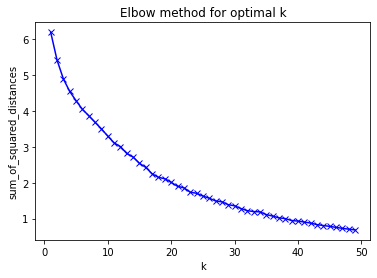

In [31]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow method for optimal k')

The Silhouette Method


In [32]:
sil = []
K_sil = range(2,50)

for k in K_sil:
  print(k, end=' ')
  kmeans = KMeans(n_clusters=k).fit(busan_grouped_clustering)
  labels = kmeans.labels_
  sil.append(silhouette_score(busan_grouped_clustering, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

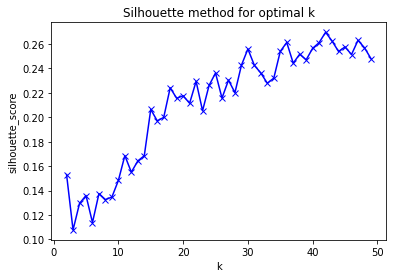

In [33]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette method for optimal k')
plt.show()

In [34]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(busan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 1, 1, 1, 3, 1, 1, 6, 1, 1], dtype=int32)

In [35]:
busan_grouped_clustering.head()

,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Garden,Big Box Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Bossam/Jokbal Restaurant,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Bunsik Restaurant,Burger Joint,Bus Line,Bus Stop,Cable Car,Café,Casino,Cemetery,...,Ramen Restaurant,Resort,Rest Area,Restaurant,River,Rock Club,Russian Restaurant,Sake Bar,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shopping Mall,Skating Rink,Smoothie Shop,Snack Place,Soccer Stadium,Spa,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tea Room,Temple,Thai Restaurant,Theater,Theme Park Ride / Attraction,Toll Booth,Toll Plaza,Toy / Game Store,Track Stadium,Trail,Tunnel,Turkish Restaurant,Used Bookstore,Vietnamese Restaurant,Warehouse Store,Wings Joint
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.010000,0.0,0.01,0.02,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.01,0.0,0.02,0.0,0.0,0.01,0.03,0.0,0.0,0.0,0.0,0.0,0.030000,0.0,0.0,...,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040000,0.01,0.01,0.0,0.0,0.0,0.02,0.0,0.01,0.020000,0.030000,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.000000,0.0,0.0,0.01,0.000000,0.000000,0.0,0.01,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.045455,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.045455,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.045455,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.045455,0.000000,0.0,0.00,0.045455,0.045455
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.00,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.111111,0.0,0.0,0.00,0.000000,0.111111,0.0,0.00,0.000000,0.000000


In [36]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

busan_merged = stations 
busan_merged = busan_merged.join(neighborhoods_venues_sorted.set_index('Station'), on='name')
busan_merged.head()

,name,categories,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bujeon Stn. (부전역),Metro Station,35.162565,129.062973,1,Coffee Shop,Multiplex,Korean Restaurant,Department Store,Italian Restaurant,Noodle House,Big Box Store,Bookstore,Fast Food Restaurant,Hotel
1,Seomyeon Stn. (서면역),Metro Station,35.157718,129.059181,1,Coffee Shop,Korean Restaurant,Fast Food Restaurant,Multiplex,Department Store,Gukbap Restaurant,Big Box Store,Bookstore,Italian Restaurant,Noodle House
2,Yeonsan Stn. (연산역),Metro Station,35.186107,129.081523,3,Coffee Shop,Korean Restaurant,Fast Food Restaurant,Supermarket,Intersection,Bakery,Chinese Restaurant,Market,Multiplex,Donut Shop
3,Yangjeong Stn. (양정역),Metro Station,35.173009,129.071133,1,Coffee Shop,Fast Food Restaurant,Hotel,Big Box Store,BBQ Joint,Donut Shop,Bed & Breakfast,Supermarket,Multiplex,Scenic Lookout
4,Sajik Stn. (사직역),Metro Station,35.199044,129.065065,3,Coffee Shop,Korean Restaurant,Fast Food Restaurant,Multiplex,Supermarket,Tunnel,Trail,Track Stadium,Café,Big Box Store


Check Clusters.

In [37]:
busan_merged.groupby('Cluster Labels').count()


,name,categories,lat,lng,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,
0,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1,39,39,39,39,39,39,39,39,39,39,39,39,39,39
2,20,20,20,20,20,20,20,20,20,20,20,20,20,20
3,32,32,32,32,32,32,32,32,32,32,32,32,32,32
4,3,3,3,3,3,3,3,3,3,3,3,3,3,3
5,9,9,9,9,9,9,9,9,9,9,9,9,9,9
6,17,17,17,17,17,17,17,17,17,17,17,17,17,17
7,11,11,11,11,11,11,11,11,11,11,11,11,11,11


Cluster 1

In [42]:
busan_merged[busan_merged['Cluster Labels'] == 1]

,name,categories,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bujeon Stn. (부전역),Metro Station,35.162565,129.062973,1,Coffee Shop,Multiplex,Korean Restaurant,Department Store,Italian Restaurant,Noodle House,Big Box Store,Bookstore,Fast Food Restaurant,Hotel
1,Seomyeon Stn. (서면역),Metro Station,35.157718,129.059181,1,Coffee Shop,Korean Restaurant,Fast Food Restaurant,Multiplex,Department Store,Gukbap Restaurant,Big Box Store,Bookstore,Italian Restaurant,Noodle House
3,Yangjeong Stn. (양정역),Metro Station,35.173009,129.071133,1,Coffee Shop,Fast Food Restaurant,Hotel,Big Box Store,BBQ Joint,Donut Shop,Bed & Breakfast,Supermarket,Multiplex,Scenic Lookout
5,Jeonpo Stn. (전포역),Metro Station,35.152793,129.065387,1,Coffee Shop,Korean Restaurant,Multiplex,Department Store,Gukbap Restaurant,Big Box Store,Hotel,Market,Italian Restaurant,Bookstore
6,Geojehaemaji Stn. (거제해맞이역),Metro Station,35.181403,129.068949,1,Coffee Shop,Fast Food Restaurant,Park,Korean Restaurant,Supermarket,Donut Shop,Dumpling Restaurant,Multiplex,Basketball Stadium,Sushi Restaurant
7,Bujeon Stn. - Korail (부전역),Train Station,35.164038,129.060452,1,Coffee Shop,Korean Restaurant,Multiplex,Noodle House,Department Store,Italian Restaurant,Bookstore,Big Box Store,Fast Food Restaurant,Hotel
8,City Hall Stn. (시청역),Metro Station,35.179824,129.076642,1,Coffee Shop,Fast Food Restaurant,Supermarket,Bakery,Dessert Shop,Korean Restaurant,Multiplex,Bridal Shop,Sushi Restaurant,Intersection
9,Buam Stn. (부암역),Metro Station,35.157407,129.050496,1,Coffee Shop,Korean Restaurant,Department Store,Multiplex,Noodle House,Gukbap Restaurant,Italian Restaurant,Bookstore,Fast Food Restaurant,Big Box Store
10,Mulmangol Stn. (물만골역),Metro Station,35.176632,129.085815,1,Coffee Shop,Fast Food Restaurant,Supermarket,Hotel,River,Asian Restaurant,Sushi Restaurant,BBQ Joint,Outdoor Sculpture,Department Store
11,Beomnaegol Stn. (범내골역),Metro Station,35.147612,129.059198,1,Coffee Shop,Korean Restaurant,Department Store,Multiplex,Gukbap Restaurant,Hotel,Noodle House,Big Box Store,Market,Italian Restaurant


In [39]:
# Update map
map_clusters = folium.Map(width=800,height=500, location=[busan_lat, busan_long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(busan_merged['lat'], busan_merged['lng'], busan_merged['name'], busan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters